In [1]:
import pandas as pd
import numpy as np

test_data = pd.read_csv("ab_test_data.csv", parse_dates=['timestamp'])
display(test_data.head())

,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0


In [2]:
print('Sample size: a - {}, b - {}'.format(*test_data.groupby('test_group').size()))
print('Conversions: a - {}, b - {}'.format(*test_data[test_data['conversion'] == 1].groupby('test_group').size()))
print('Conversion Rate: a - {}, b - {}'.format(*(test_data.groupby('test_group')['conversion'].mean()*100).round(2)))
print(f"Start date: {test_data['timestamp'].dt.date.astype(str).min()}")
print(f"Finish date: {test_data['timestamp'].dt.date.astype(str).max()}")
print(f"Test duration: {(test_data['timestamp'].dt.date.max() - test_data['timestamp'].dt.date.min()).days}")

Sample size: a - 10013, b - 9985
Conversions: a - 611, b - 889
Conversion Rate: a - 6.1, b - 8.9
Start date: 2023-07-03
Finish date: 2023-07-25
Test duration: 22


In [3]:
test_data.describe(include = 'all')

,user_id,timestamp,test_group,conversion
count,19998,19998,19998,19998.000000
unique,19998,NaN,2,NaN
top,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,NaN,a,NaN
freq,1,NaN,10013,NaN
mean,NaN,2023-07-14 00:06:01.194764032,NaN,0.075008
min,NaN,2023-07-03 01:42:34.033708,NaN,0.000000
25%,NaN,2023-07-08 11:10:21.252182528,NaN,0.000000
50%,NaN,2023-07-13 23:41:16.368097536,NaN,0.000000
75%,NaN,2023-07-19 12:24:31.061365760,NaN,0.000000
max,NaN,2023-07-25 01:41:19.152664,NaN,1.000000


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     19998 non-null  object        
 1   timestamp   19998 non-null  datetime64[ns]
 2   test_group  19998 non-null  object        
 3   conversion  19998 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 625.1+ KB


In [5]:
test_data.groupby('test_group').describe(include=[np.number])

conversion                                             
                count      mean       std  min  25%  50%  75%  max
test_group                                                        
a             10013.0  0.061021  0.239380  0.0  0.0  0.0  0.0  1.0
b              9985.0  0.089034  0.284806  0.0  0.0  0.0  0.0  1.0

In [6]:
test_data[(test_data['test_group'] == 'a') & (test_data['conversion'] == 1)]['conversion'].count()

611

In [7]:
test_data[(test_data['test_group'] == 'b') & (test_data['conversion'] == 1)]['conversion'].count()

889

In [8]:
from scipy import stats

alpha = 0.05

statistic, pvalue = stats.ttest_ind(test_data[test_data['test_group'] == 'a']['conversion'],
                                    test_data[test_data['test_group'] == 'b']['conversion'], 
                                    alternative='less')

print(f't-statistic: {round(statistic, 2)}, p-value: {round(pvalue, 2)}')

if pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')

t-statistic: -7.53, p-value: 0.0
The difference is statistically significant, Null Hypothesis is rejected.


In [9]:
from scipy import stats

def statistic(x, y):
    return stats.ttest_ind(x, y).statistic

alpha = 0.05
    
x = test_data[test_data['test_group'] == 'a']['conversion']
y = test_data[test_data['test_group'] == 'b']['conversion']

results = stats.permutation_test((x, y), statistic, n_resamples=100)

print(f'statistic: {round(results.statistic, 2)}, p-value: {round(results.pvalue, 2)}')

if results.pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')

statistic: -7.53, p-value: 0.02
The difference is statistically significant, Null Hypothesis is rejected.


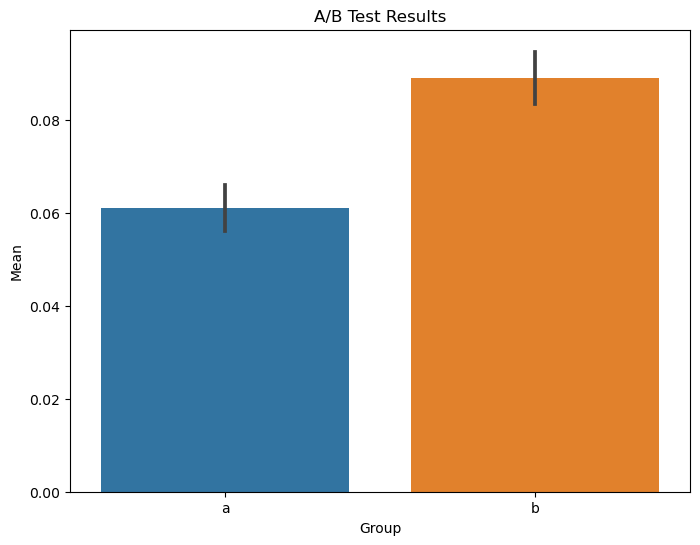

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=test_data['test_group'], 
            y=test_data['conversion'], 
            errorbar=('ci', 95)) # Confidence Intervals

plt.title('A/B Test Results')
plt.xlabel('Group')
plt.ylabel('Mean')
plt.savefig('ab_test_results.png')
plt.show()

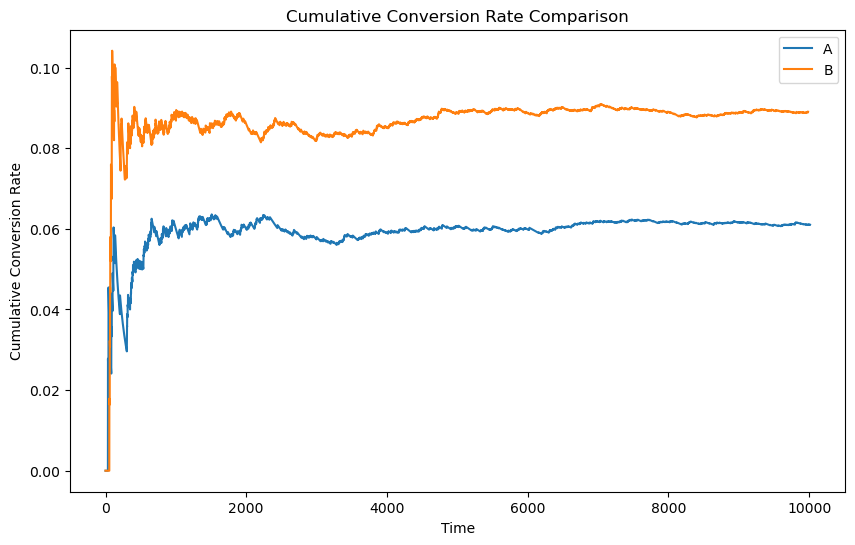

In [11]:
cumulative_metric_a = test_data[test_data['test_group'] == 'a'].sort_values(by = 'timestamp')['conversion'].expanding().mean().reset_index(drop=True)
cumulative_metric_b = test_data[test_data['test_group'] == 'b'].sort_values(by = 'timestamp')['conversion'].expanding().mean().reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_metric_a, label='A')
plt.plot(cumulative_metric_b, label='B')

plt.title('Cumulative Сonversion Rate Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Сonversion Rate')

plt.legend()
plt.savefig('Cumulative_Сonversion_Rate_Comparison.png')
plt.show()